In [1]:
### установка недостающих пакетов 
!pip install psycopg2-binary

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 30.8 MB/s eta 0:00:00a 0:00:01


In [2]:
### импорт основных модулей, остальное по мере необходимости
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
from category_encoders.one_hot import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline

matplotlib.rcParams['figure.figsize'] = (8, 5)

import warnings
warnings.filterwarnings('ignore')

# Выгрузка и проверка данных из таблиц

In [14]:
### подключение, реальные доступы убраны из ячейки
conn_uri = "postgresql://логин:пароль@путь:порт"

In [4]:
### таблица users
    
df_user = pd.read_sql(
    """
    SELECT * 
    FROM "user_data" 
    """,
    con=conn_uri
)

df_user

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads
...,...,...,...,...,...,...,...,...
163200,168548,0,36,Russia,Kaliningrad,4,Android,organic
163201,168549,0,18,Russia,Tula,2,Android,organic
163202,168550,1,41,Russia,Yekaterinburg,4,Android,organic
163203,168551,0,38,Russia,Moscow,3,iOS,organic


In [6]:
## таблица posts
df_post = pd.read_sql(
    """
    SELECT * 
    FROM "post_text_df" 
    """,
    con=conn_uri
)

df_post

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business
...,...,...,...
7018,7315,"OK, I would not normally watch a Farrelly brot...",movie
7019,7316,I give this movie 2 stars purely because of it...,movie
7020,7317,I cant believe this film was allowed to be mad...,movie
7021,7318,The version I saw of this film was the Blockbu...,movie


In [15]:
### проверим таблицу feed, так как было предупреждение о большом объеме данных
df_feed_shape = pd.read_sql(
    """
    SELECT COUNT(*)
    FROM "feed_data"
    
    """,
    con=conn_uri
)
df_feed_shape

,count
0,76892800


In [7]:
%%time
### выходит порядка 77 млн записей, для анализа отберем порядка 1 млн записей 
### (для обучения позже выгрузим уже объемнее)
### нашел код для выгрузки случайных записей с % параметром TABLESAMPLE BERNOULLI
### берем записи =view, т.к. =like всегда имеет значение таргета 0 по логике формирования этой таблицы

df_feed = pd.read_sql(
    """
    SELECT *
    FROM "feed_data"
    TABLESAMPLE BERNOULLI(1.5)
    WHERE action = 'view'
    """,
    con=conn_uri
)

df_feed.head()

CPU times: user 3.5 s, sys: 464 ms, total: 3.96 s
Wall time: 18.3 s


,timestamp,user_id,post_id,action,target
0,2021-10-01 23:00:47,97671,2986,view,0
1,2021-10-29 16:42:12,97671,2446,view,0
2,2021-10-15 10:43:36,154231,649,view,0
3,2021-11-04 16:48:33,154231,1098,view,0
4,2021-10-10 09:25:34,166075,6636,view,0


In [8]:
### соберем в один df для последующей проверки и eda
### удалим колонку action, т. к. она неинформативна 
df = df_feed.merge(df_user,
                  how="left",
                  on="user_id")
df = df.merge(df_post,
                  how="left",
                  on="post_id")\
        .drop("action", axis=1)
df.head()

,timestamp,user_id,post_id,target,gender,age,country,city,exp_group,os,source,text,topic
0,2021-10-01 23:00:47,97671,2986,0,1,23,Russia,Noginsk,4,Android,ads,#2020 has a joke to share but nobody is ready ...,covid
1,2021-10-29 16:42:12,97671,2446,0,1,23,Russia,Noginsk,4,Android,ads,@LozzaFox Opening yourself up for one hell of ...,covid
2,2021-10-15 10:43:36,154231,649,0,0,51,Russia,Novokuznetsk,0,Android,organic,Comeback show for Friends star\n\nFriends actr...,entertainment
3,2021-11-04 16:48:33,154231,1098,0,0,51,Russia,Novokuznetsk,0,Android,organic,Police urge pub closure power\n\nNew powers ar...,politics
4,2021-10-10 09:25:34,166075,6636,0,0,22,Russia,Moscow,1,Android,organic,"I watched this movie, or part of it, in hope t...",movie


# Простой EDA перед подготовкой к обучению

Проверим наличие пропусков и посмотрим на типы данных

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030285 entries, 0 to 1030284
Data columns (total 13 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   timestamp  1030285 non-null  datetime64[ns]
 1   user_id    1030285 non-null  int64         
 2   post_id    1030285 non-null  int64         
 3   target     1030285 non-null  int64         
 4   gender     1030285 non-null  int64         
 5   age        1030285 non-null  int64         
 6   country    1030285 non-null  object        
 7   city       1030285 non-null  object        
 8   exp_group  1030285 non-null  int64         
 9   os         1030285 non-null  object        
 10  source     1030285 non-null  object        
 11  text       1030285 non-null  object        
 12  topic      1030285 non-null  object        
dtypes: datetime64[ns](1), int64(6), object(6)
memory usage: 102.2+ MB


___
Выделим еще отдельные фичи, которые можно по-быстрому добавить в df, связаннные со временем и проведем eda с ними вместе, все пункты гипотетические и под вопросом по поводу информативности для будущей модели:
* час
* день недели
* будний/выходной
* месяц

In [20]:
df["hour_cat"]= df['timestamp'].dt.hour
df["day_of_week_cat"]= df['timestamp'].dt.dayofweek
df["weekday_cat"] = df["day_of_week_cat"].map({5: "wend", 6: "wend"}).fillna("wday")
df["month_cat"] = df['timestamp'].dt.month

___
Категориальные фичи для eda

In [23]:
categorical_columns_eda = ['gender', 'age', 'country', 
                           'exp_group', 'os', 'source', 'topic', 
                           'hour_cat', 'day_of_week_cat', 'weekday_cat', 'month_cat']

___
Проверим баланс классов таргета. 
Оказалось несбалансированным, оценку будем делать по roc_auc как наиболее универсальную для задач бинарной классификации (хотя можно еще в принципе использовать pr-roc или f-меру)

In [24]:
df['target'].value_counts()

target
0    907101
1    123184
Name: count, dtype: int64

___
Построим гистрограммы распределения категорий в зависимости от класса.
Небольшие отличия у фичей:
* **os, source, weekday_cat**

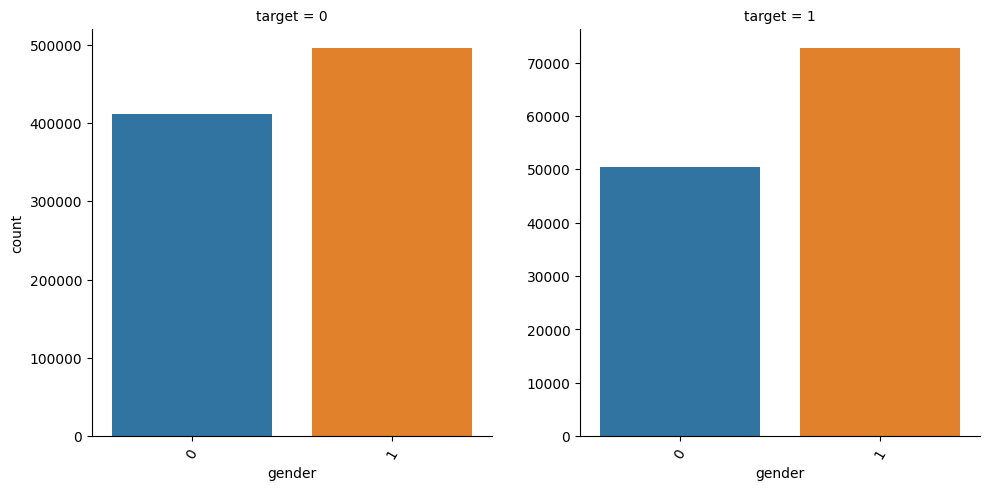

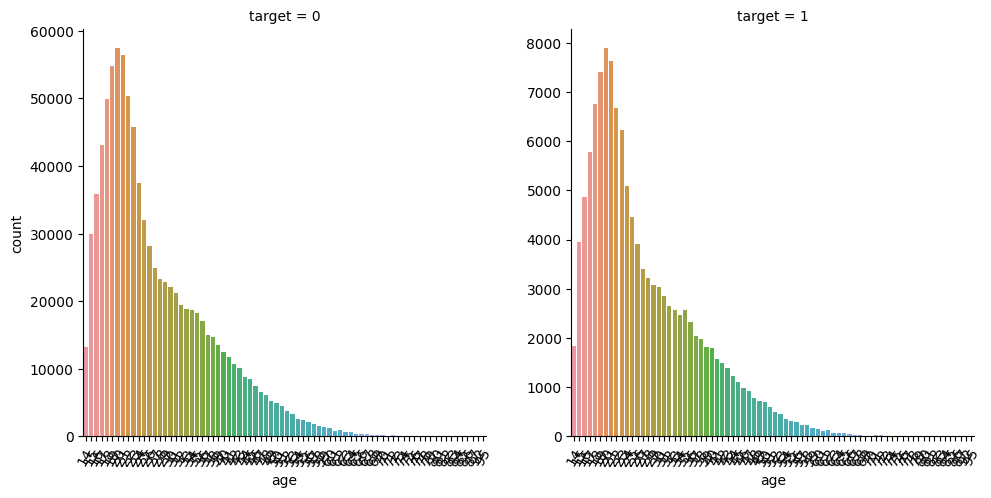

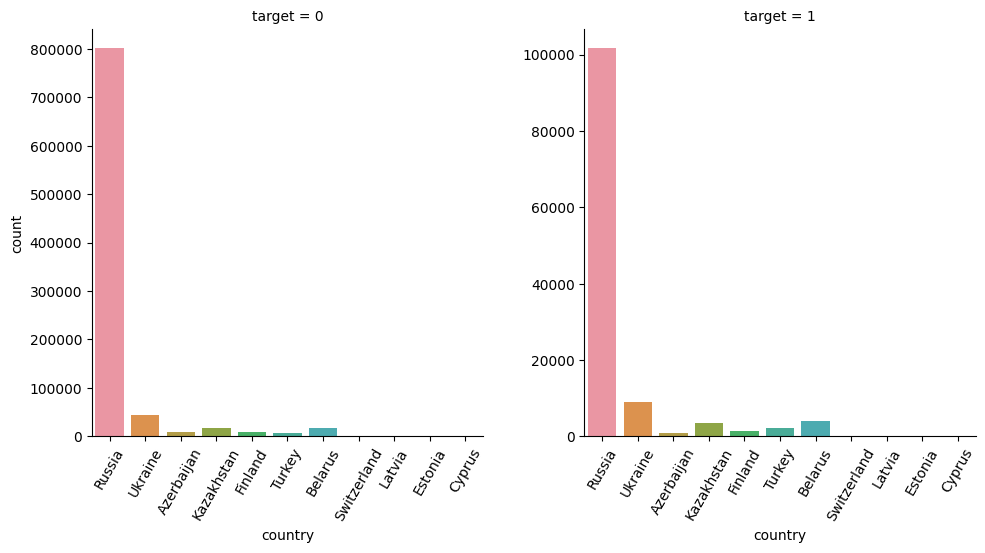

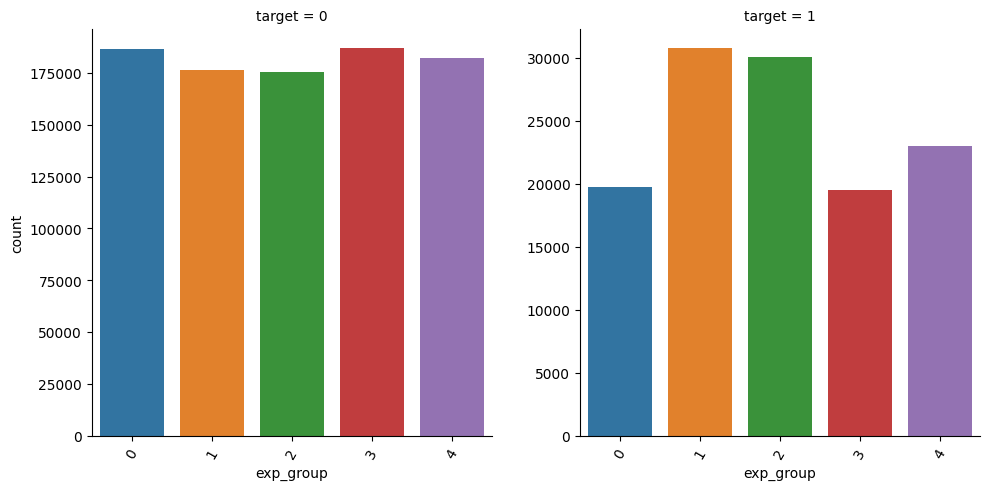

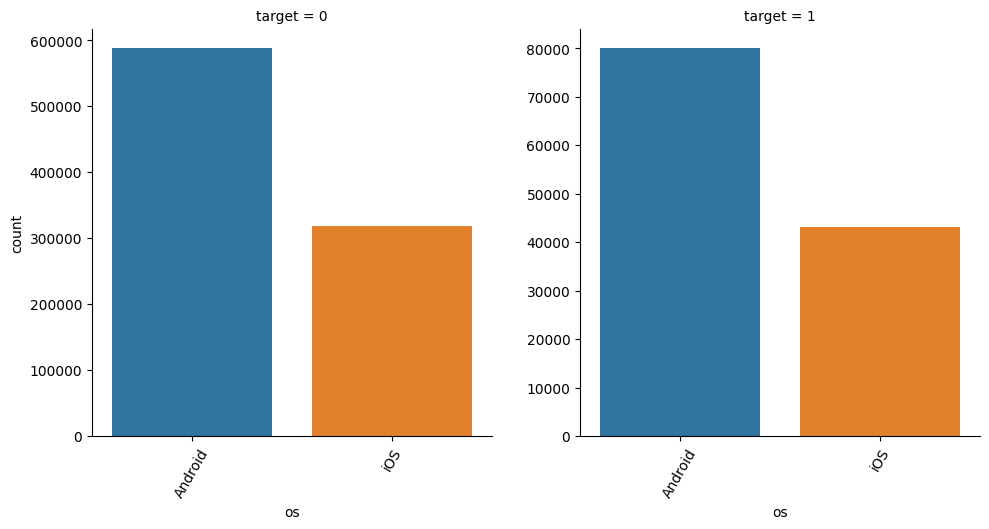

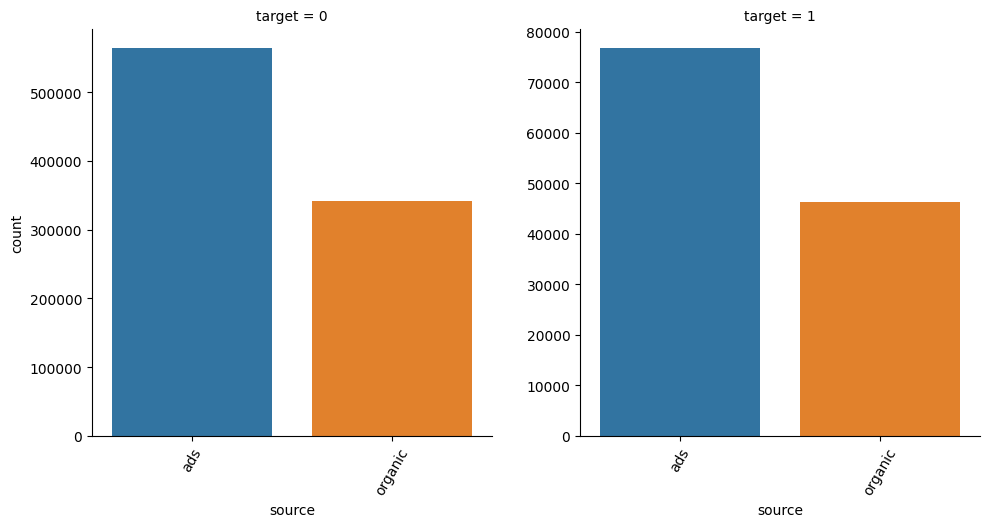

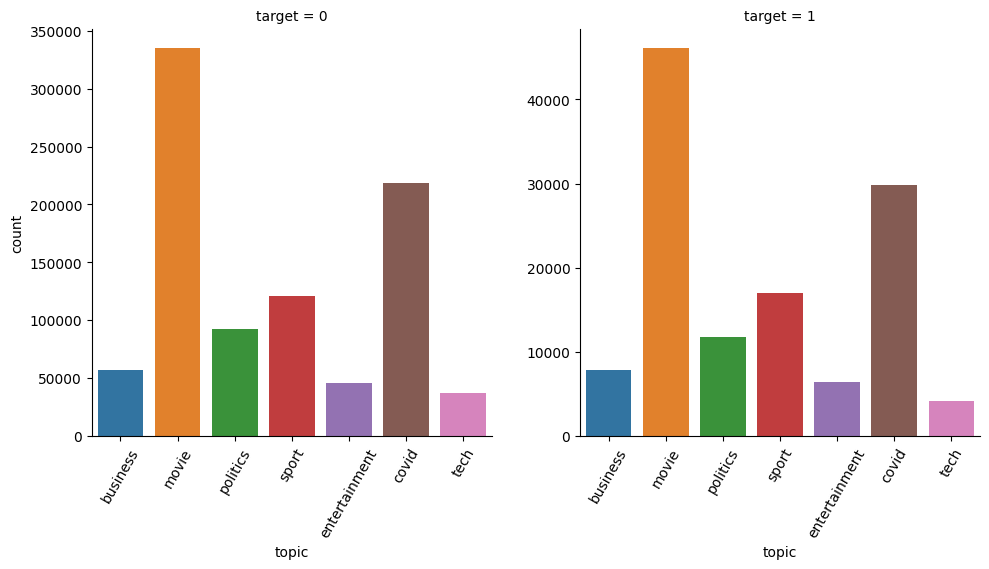

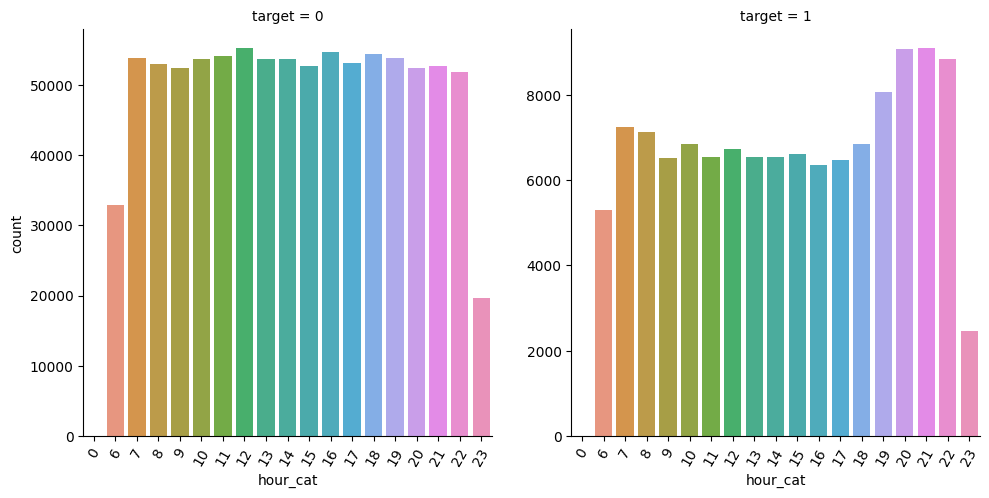

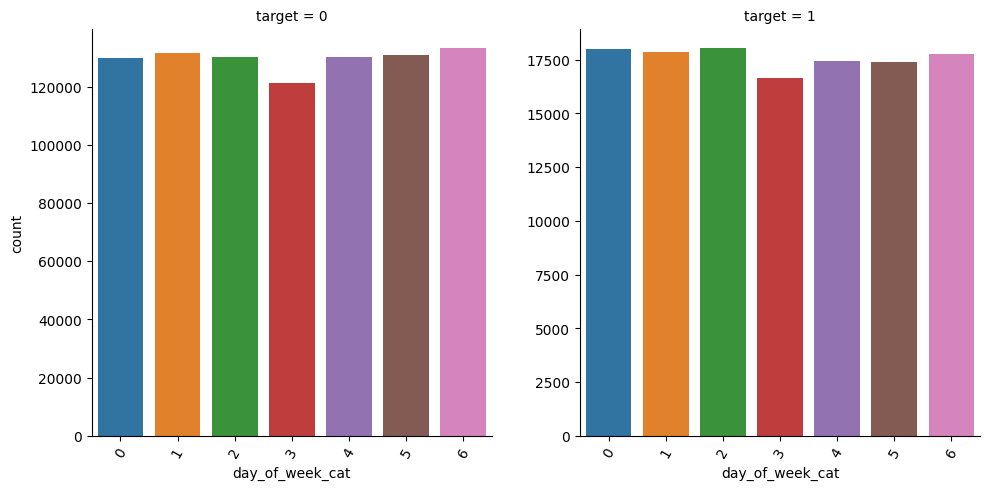

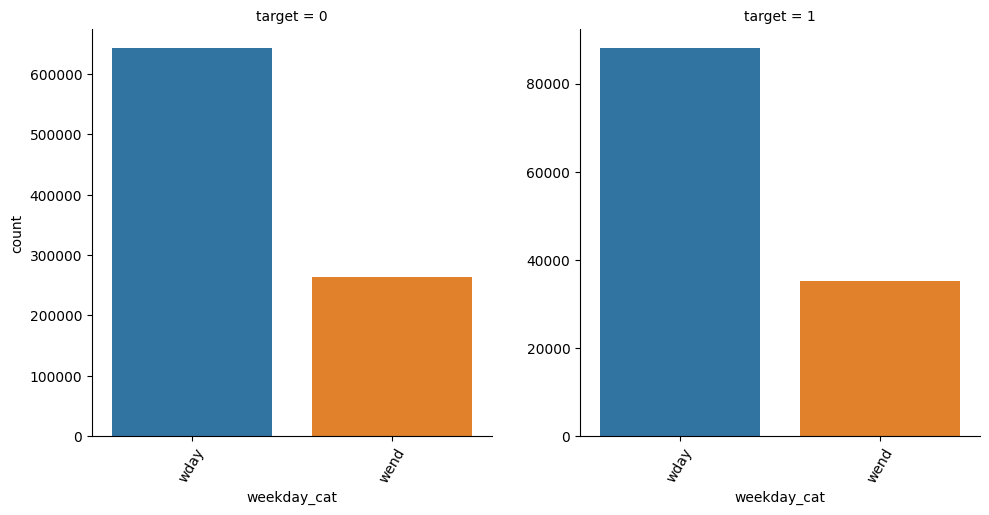

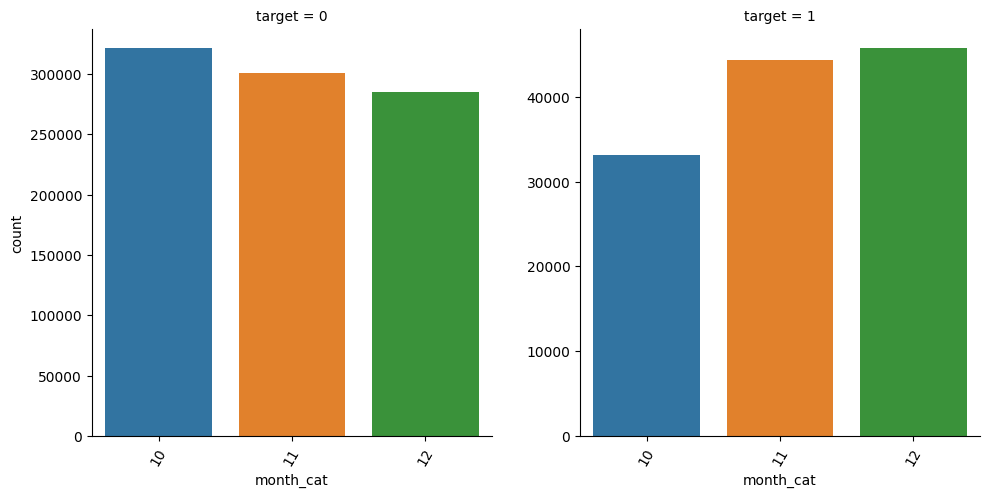

In [29]:
for col in categorical_columns_eda:
    g = sns.catplot(x=col,
                    kind='count',
                    col='target',
                    data=df,
                    sharey=False)
    g.set_xticklabels(rotation=60)

___
Городов вышло очень много для сравнения по таргету. Выделим из них самые основные по количеству в размере 10 шт. и также сделаем гистограмму

In [52]:
most_cities = (df['city'].value_counts(normalize=True) * 100)[:10].index.tolist()

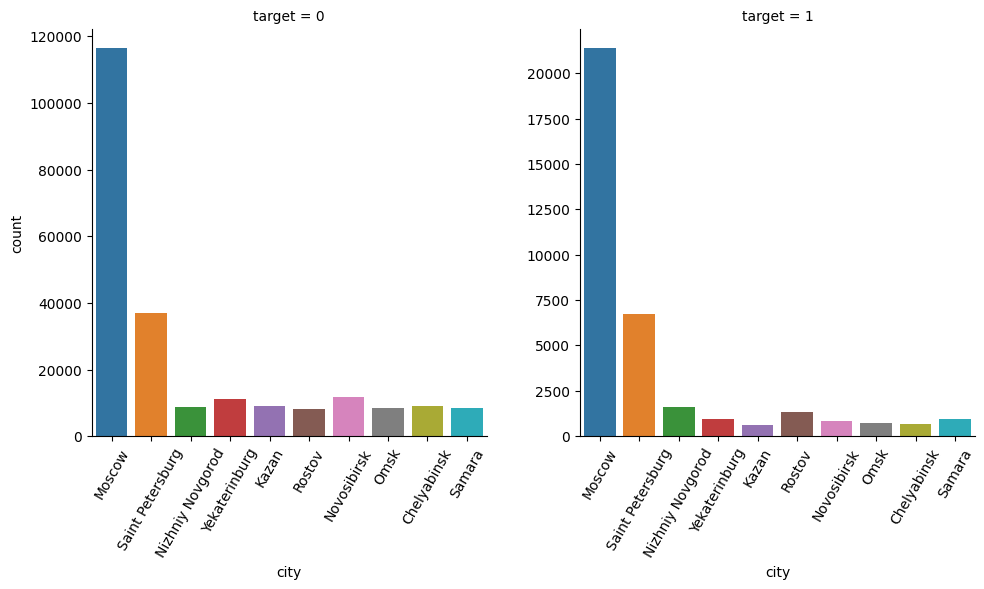

In [54]:
g_c = sns.catplot(x='city',
                    kind='count',
                    col='target',
                    data=df[df['city'].isin(most_cities)],
                    sharey=False)
g_c.set_xticklabels(rotation=60)

В итоге от следующих фичей **можно отказаться** по сути: **os, source, weekday_cat** . И еще под вопросом country, так как значительно превалирует Россия в данных, информация может быть избыточной


___

# Доп фичи на основе текстов постов
Посчитаем для слов постов tf-idf и сделаем для них агрегацию

Немного очистим текст и лемматизируем

In [7]:
## чтобы лемматизатор заработал
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [8]:
import re
import string
from nltk.stem import WordNetLemmatizer

wnl = WordNetLemmatizer()

def preprocessing(line, token=wnl):
    line = line.lower()
    line = re.sub(r"[{}]".format(string.punctuation), " ", line)
    line = line.replace('\n\n', ' ').replace('\n', ' ')
    line = ' '.join([token.lemmatize(x) for x in line.split(' ')])
    return line

tfidf = TfidfVectorizer(
    stop_words='english',
    preprocessor=preprocessing
)

In [9]:
tfidf_data = (
    tfidf.fit_transform(df_post['text']).toarray()
)
tfidf_df = pd.DataFrame(
    tfidf_data,
    index=df_post.index,
    columns=tfidf.get_feature_names_out()
)
tfidf_df.head(2)

,00,000,0001,000bn,000m,000s,000th,001,001and,001st,...,𝓫𝓮,𝓫𝓮𝓽𝓽𝓮𝓻,𝓬𝓸𝓾𝓻𝓽𝓼,𝓱𝓮𝓪𝓻𝓲𝓷𝓰,𝓶𝓪𝔂,𝓹𝓱𝔂𝓼𝓲𝓬𝓪𝓵,𝓼𝓸𝓸𝓷𝓮𝓻,𝓼𝓾𝓫𝓸𝓻𝓭𝓲𝓷𝓪𝓽𝓮,𝓽𝓱𝓮,𝓽𝓸
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.132739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Добавим агрегацию по tf_idf к данным постов

In [10]:
## добавляем новые фичи в df_post
df_post['TotalTfIdf'] = tfidf_df.sum(axis=1)
df_post['MaxTfIdf'] = tfidf_df.max(axis=1)
df_post['MeanTfIdf'] = tfidf_df.mean(axis=1)
df_post.head()

,post_id,text,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf
0,1,UK economy facing major risks\n\nThe UK manufa...,business,8.748129,0.495805,0.000190
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,11.878472,0.308003,0.000258
2,3,Asian quake hits European shares\n\nShares in ...,business,12.675530,0.261799,0.000276
3,4,India power shares jump on debut\n\nShares in ...,business,6.622786,0.537713,0.000144
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,6.352096,0.420251,0.000138


# Подготовка к обучению

Выгрузим для обучения больше данных, возьмем порядка 8 млн (было заранее отдельно выгружено, чтобы постоянно не грузить большое количество данных, код просто сохранен)



In [ ]:
df_feed = pd.read_sql(
    """
    SELECT * 
    FROM feed_data 
    TABLESAMPLE BERNOULLI(12) 
    WHERE action = 'view'
    """,
    con=conn_uri
)

In [10]:
# сохраненный фид из csv
df_feed = pd.read_csv('/kaggle/input/df-feed-final-2/df_feed.csv', sep=";").drop('Unnamed: 0', axis=1)
df_feed['timestamp'] = pd.to_datetime(df_feed['timestamp'])
df_feed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8241291 entries, 0 to 8241290
Data columns (total 5 columns):
 #   Column     Dtype         
---  ------     -----         
 0   timestamp  datetime64[ns]
 1   user_id    int64         
 2   post_id    int64         
 3   action     object        
 4   target     int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 314.4+ MB


Уберем у users спорные колонки os и source

In [11]:
df_user = df_user.drop(['os', 'source'], axis=1)

Мержим таблицы в фид

In [12]:
df = pd.merge(
    df_feed,
    df_post,
    on='post_id',
    how='left'
                
)
df = pd.merge(
    df,
    df_user,
    on='user_id',
    how='left'
                
)
df

,timestamp,user_id,post_id,action,target,text,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf,gender,age,country,city,exp_group
0,2021-10-26 23:04:29,18548,4312,view,0,I had the (mis)fortune to see this film at a s...,movie,8.320077,0.287743,0.000181,1,20,Russia,Moscow,2
1,2021-10-26 23:07:02,18548,4665,view,0,This one is a very solid Randolph Scott Wester...,movie,5.489668,0.385140,0.000119,1,20,Russia,Moscow,2
2,2021-10-27 20:03:31,18548,4466,view,1,This was without a doubt the worst movie I hav...,movie,6.364922,0.241490,0.000138,1,20,Russia,Moscow,2
3,2021-10-27 20:05:35,18548,3320,view,0,Karnataka: The office of Department of Informa...,covid,3.096677,0.409700,0.000067,1,20,Russia,Moscow,2
4,2021-10-27 20:07:14,18548,5902,view,0,Many of the classic films of the late 60s have...,movie,9.321593,0.208704,0.000203,1,20,Russia,Moscow,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8241286,2021-10-16 14:27:31,18548,1486,view,1,Newcastle 2-1 Bolton\n\nKieron Dyer smashed ho...,sport,11.917832,0.343943,0.000259,1,20,Russia,Moscow,2
8241287,2021-10-16 15:00:29,18548,6718,view,0,I got to watch this movie in my french class a...,movie,5.692200,0.389157,0.000124,1,20,Russia,Moscow,2
8241288,2021-10-23 16:33:37,18548,4046,view,0,"Regardless of your age, you need to be aware o...",covid,3.066039,0.467842,0.000067,1,20,Russia,Moscow,2
8241289,2021-10-23 16:47:27,18548,1760,view,0,Mourinho takes swipe at Arsenal\n\nChelsea bos...,sport,6.920512,0.467229,0.000150,1,20,Russia,Moscow,2


Добавляем фичи по времени (исключая weekday_cat)

In [13]:
df["hour_cat"]= df['timestamp'].dt.hour
df["day_of_week_cat"]= df['timestamp'].dt.dayofweek
df["month_cat"] = df['timestamp'].dt.month

Удаляем лишние колонки action и text, а user_id и post_id сделаем индексом

In [14]:
df = df.drop([
    'action',
    'text',
],
axis=1)

df = df.set_index(['user_id', 'post_id'])
df.head(10)

timestamp  target     topic  TotalTfIdf  MaxTfIdf  \
user_id post_id                                                               
18548   4312    2021-10-26 23:04:29       0     movie    8.320077  0.287743   
        4665    2021-10-26 23:07:02       0     movie    5.489668  0.385140   
        4466    2021-10-27 20:03:31       1     movie    6.364922  0.241490   
        3320    2021-10-27 20:05:35       0     covid    3.096677  0.409700   
        5902    2021-10-27 20:07:14       0     movie    9.321593  0.208704   
        4747    2021-10-28 15:43:59       0     movie    8.961848  0.378034   
        4071    2021-10-28 15:49:08       0     covid    3.332733  0.436395   
        1261    2021-10-28 15:50:45       0  politics    9.438018  0.318238   
        7124    2021-10-28 15:51:32       1     movie    7.221192  0.282413   
        3907    2021-10-28 15:57:38       1     covid    3.291812  0.406722   

                 MeanTfIdf  gender  age country    city  exp_group  hour_cat  \
user_id post_id                                                                
18548   4312      0.000181       1   20  Russia  Moscow          2        23   
        4665      0.000119       1   20  Russia  Moscow          2        23   
        4466      0.000138       1   20  Russia  Moscow          2        20   
        3320      0.000067       1   20  Russia  Moscow          2        20   
        5902      0.000203       1   20  Russia  Moscow          2        20   
        4747      0.000195       1   20  Russia  Moscow          2        15   
        4071      0.000072       1   20  Russia  Moscow          2        15   
        1261      0.000205       1   20  Russia  Moscow          2        15   
        7124      0.000157       1   20  Russia  Moscow          2        15   
        3907      0.000072       1   20  Russia  Moscow          2        15   

                 day_of_week_cat  month_cat  
user_id post_id                              
18548   4312                   1         10  
        4665                   1         10  
        4466                   2         10  
        3320                   2         10  
        5902                   2         10  
        4747                   3         10  
        4071                   3         10  
        1261                   3         10  
        7124                   3         10  
        3907                   3         10

Для валидации будем использовать отложенную выборку по дате (так как нам необходимо по сути предсказывать данные на будущее), сделаем сплит по дате 2021-12-15 

In [70]:
max(df.timestamp), min(df.timestamp)

(Timestamp('2021-12-29 23:51:06'), Timestamp('2021-10-01 06:01:40'))

In [15]:
## сплитим по 2021-12-15
df_train = df[df.timestamp < '2021-12-15']
df_test = df[df.timestamp >= '2021-12-15']

X_train = df_train.drop(['target', 'timestamp'], axis=1)
X_test = df_test.drop(['target', 'timestamp'], axis=1)

y_train = df_train['target']
y_test = df_test['target']

y_train.shape, y_test.shape

((6869913,), (1371378,))

In [16]:
X_train.head()

topic  TotalTfIdf  MaxTfIdf  MeanTfIdf  gender  age country  \
user_id post_id                                                                
18548   4312     movie    8.320077  0.287743   0.000181       1   20  Russia   
        4665     movie    5.489668  0.385140   0.000119       1   20  Russia   
        4466     movie    6.364922  0.241490   0.000138       1   20  Russia   
        3320     covid    3.096677  0.409700   0.000067       1   20  Russia   
        5902     movie    9.321593  0.208704   0.000203       1   20  Russia   

                   city  exp_group  hour_cat  day_of_week_cat  month_cat  
user_id post_id                                                           
18548   4312     Moscow          2        23                1         10  
        4665     Moscow          2        23                1         10  
        4466     Moscow          2        20                2         10  
        3320     Moscow          2        20                2         10  
        5902     Moscow          2        20                2         10

In [23]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6869913 entries, (18548, 4312) to (18548, 5589)
Data columns (total 12 columns):
 #   Column           Dtype  
---  ------           -----  
 0   topic            object 
 1   TotalTfIdf       float64
 2   MaxTfIdf         float64
 3   MeanTfIdf        float64
 4   gender           object 
 5   age              int64  
 6   country          object 
 7   city             object 
 8   exp_group        object 
 9   hour_cat         object 
 10  day_of_week_cat  object 
 11  month_cat        object 
dtypes: float64(3), int64(1), object(8)
memory usage: 673.8+ MB


Делаем трансформирование данных и выделение категориальных фичей. для катбуста достаточно просто указание категориальных фичей

In [22]:
object_cols = [
    'topic', 'gender', 'country', 'city',
    'exp_group', 'hour_cat', 'day_of_week_cat', 'month_cat'
]

for col in object_cols:
    X_train[col] = X_train[col].astype('object')
    X_test[col] = X_test[col].astype('object')

In [24]:

cols_for_one = [x for x in object_cols if X_train[x].nunique() < 5]
cols_for_mte = [x for x in object_cols if X_train[x].nunique() >= 5]

cols_for_one_idx = [list(X_train.columns).index(col) for col in cols_for_one]
cols_for_mte_idx = [list(X_train.columns).index(col) for col in cols_for_mte]

t = [
    ('OneHotEncoder', OneHotEncoder(), cols_for_one_idx),
    ('MeanTargetEncoder', TargetEncoder(), cols_for_mte_idx),
]

col_transform = ColumnTransformer(transformers=t)

In [25]:
del tfidf_data
import gc
gc.collect()

489

# Обучение
Используем для рекомендаций контентный подход: фичи юзеров + фичи постов + фичи по времени. Модель над ними для предсказания вероятности клика.
Данных много, фичи разного типа, возьмем модели помощнее чем логистическую регрессию.
Попробуем обучить по дефолту
* Решающее дерево
* Случайный лес
* Катбуст (градиентный бустинг)

In [26]:
tree_model = Pipeline([("column_transformer", col_transform),
                ("Destree_model", DecisionTreeClassifier(random_state = 1))
                ])
tree_model.fit(X_train, y_train)

In [27]:
print(f"Качество на трейне: {roc_auc_score(y_train, tree_model.predict_proba(X_train)[:, 1])}")
print(f"Качество на тесте: {roc_auc_score(y_test, tree_model.predict_proba(X_test)[:, 1])}")

Качество на трейне: 0.9427825015584623
Качество на тесте: 0.5335012324788778


In [28]:
rforest_model = Pipeline([("column_transformer", col_transform),
                ("Destree_model", RandomForestClassifier(random_state = 1))
                ])
rforest_model.fit(X_train, y_train)

Качество на трейне: 0.9427825015584623
Качество на тесте: 0.5335012324788778


In [29]:
print(f"Качество на трейне: {roc_auc_score(y_train, rforest_model.predict_proba(X_train)[:, 1])}")
print(f"Качество на тесте: {roc_auc_score(y_test, rforest_model.predict_proba(X_test)[:, 1])}")

Качество на трейне: 0.9374515434705433
Качество на тесте: 0.5622512441357027


In [34]:
catboost = CatBoostClassifier(iterations=100,
                              learning_rate=1,
                              verbose=25,
                              eval_metric="AUC"
                              )

catboost.fit(X_train, y_train, object_cols, eval_set=(X_test, y_test))

0:	test: 0.5513294	best: 0.5513294 (0)	total: 1.93s	remaining: 3m 10s
25:	test: 0.6482121	best: 0.6482121 (25)	total: 39.1s	remaining: 1m 51s
50:	test: 0.6517998	best: 0.6517998 (50)	total: 1m 16s	remaining: 1m 13s
75:	test: 0.6536299	best: 0.6536299 (75)	total: 1m 53s	remaining: 35.8s
99:	test: 0.6555870	best: 0.6555870 (99)	total: 2m 29s	remaining: 0us

bestTest = 0.6555870415
bestIteration = 99



In [37]:
print(f"Качество на трейне: {roc_auc_score(y_train, catboost.predict_proba(X_train)[:, 1])}")

Качество на трейне: 0.6773872282320645


Решающее дерево и Случайный лес - переобучились. 
Катбуст при простых дефолтных настройках лучше отработал.
Попробуем ограничить глубину деревьев до 10 и сравнить с дефолтным катбустом

In [43]:
tree_model = Pipeline([("column_transformer", col_transform),
                ("Destree_model", DecisionTreeClassifier(random_state = 1, max_depth=10))
                ])
tree_model.fit(X_train, y_train)
print(f"Качество на трейне: {roc_auc_score(y_train, tree_model.predict_proba(X_train)[:, 1])}")
print(f"Качество на тесте: {roc_auc_score(y_test, tree_model.predict_proba(X_test)[:, 1])}")

Качество на трейне: 0.6564545726984977
Качество на тесте: 0.6301413454011935


In [44]:
rforest_model = Pipeline([("column_transformer", col_transform),
                ("Destree_model", RandomForestClassifier(random_state = 1, max_depth=10, verbose=1))
                ])
rforest_model.fit(X_train, y_train)
print(f"Качество на трейне: {roc_auc_score(y_train, rforest_model.predict_proba(X_train)[:, 1])}")
print(f"Качество на тесте: {roc_auc_score(y_test, rforest_model.predict_proba(X_test)[:, 1])}")

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:  4.2min
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   29.7s


Качество на трейне: 0.6570164075026877


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    4.6s


Качество на тесте: 0.6314616439943982


С ограничением по глубине качество моделей стало лучше. Но лучше взять Катбуст для дальнейшего обучения, он дает лучше результат даже без явной регуляризации.

In [47]:
model_cat = CatBoostClassifier(random_state=1,
    learning_rate = 1,
    iterations=500,
    thread_count=4,
    eval_metric='AUC',
    verbose=50,
    task_type='GPU'
    )
                


model_cat.fit(X_train, 
              y_train, 
              cat_features=object_cols,
             eval_set=(X_test, y_test))

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5862621	best: 0.5862621 (0)	total: 697ms	remaining: 5m 47s
50:	test: 0.6547777	best: 0.6547777 (50)	total: 35.4s	remaining: 5m 11s
100:	test: 0.6560748	best: 0.6561075 (90)	total: 1m 14s	remaining: 4m 55s
150:	test: 0.6567586	best: 0.6567586 (150)	total: 1m 54s	remaining: 4m 25s
200:	test: 0.6574121	best: 0.6574630 (195)	total: 2m 35s	remaining: 3m 51s
250:	test: 0.6575231	best: 0.6576659 (225)	total: 3m 15s	remaining: 3m 14s
300:	test: 0.6577531	best: 0.6577613 (295)	total: 3m 56s	remaining: 2m 36s
350:	test: 0.6583627	best: 0.6583650 (340)	total: 4m 36s	remaining: 1m 57s
400:	test: 0.6585307	best: 0.6585363 (385)	total: 5m 19s	remaining: 1m 18s
450:	test: 0.6586049	best: 0.6586652 (445)	total: 6m 2s	remaining: 39.3s
499:	test: 0.6589132	best: 0.6589132 (499)	total: 6m 42s	remaining: 0us
bestTest = 0.6589131653
bestIteration = 499


Сохраним модель для подключения к сервису, а также выгрузим фичи постов для которых сделали дополнительные колонки по tf-idf

In [48]:
model_cat.save_model('catboost_model_1.cbm', format='cbm')

In [11]:
df_post.to_sql('al-smoljakov_features_lesson_22_port_1', 
                            con=conn_uri, 
                            if_exists='replace', 
                            index=False)

23

In [53]:
### проверим в порядке ли все с загруженными фичами 
pd.read_sql(
    """SELECT * FROM "al-smoljakov_features_lesson_22_port_1" """,
    
    con=conn_uri
)

,post_id,text,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf
0,1,UK economy facing major risks\n\nThe UK manufa...,business,8.748129,0.495805,0.000190
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,11.878472,0.308003,0.000258
2,3,Asian quake hits European shares\n\nShares in ...,business,12.675530,0.261799,0.000276
3,4,India power shares jump on debut\n\nShares in ...,business,6.622786,0.537713,0.000144
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,6.352096,0.420251,0.000138
...,...,...,...,...,...,...
7018,7315,"OK, I would not normally watch a Farrelly brot...",movie,6.703302,0.258412,0.000146
7019,7316,I give this movie 2 stars purely because of it...,movie,6.471377,0.399419,0.000141
7020,7317,I cant believe this film was allowed to be mad...,movie,5.628524,0.573061,0.000122
7021,7318,The version I saw of this film was the Blockbu...,movie,6.883375,0.231244,0.000150


Качество модели в чекере:
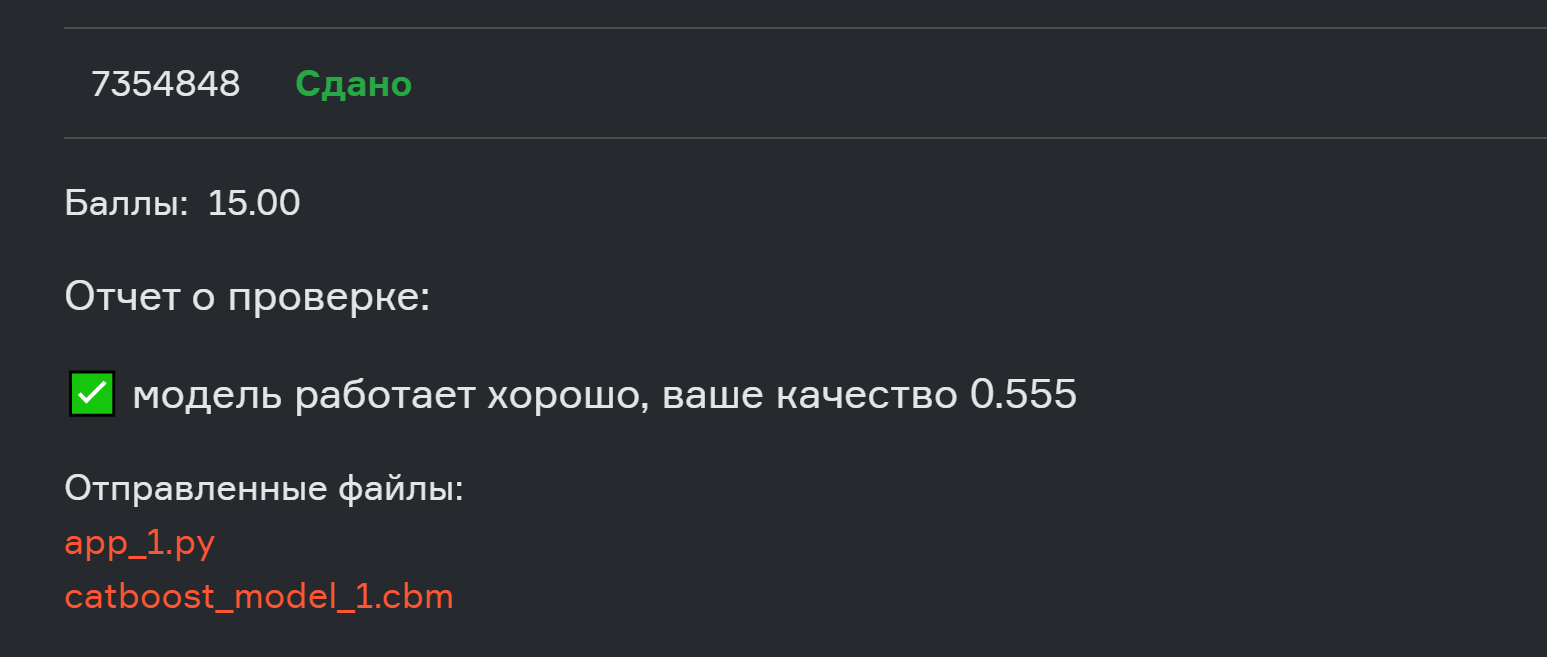
Переходим ко 2-му этапу для большего улучшения

# Обучение с добавлением эмбедингов на основе DL модели

Переходим к следующему этапу по улучшению.
Возьмем эмбединги постов выделенные с помощью обучения модели RoBerta и на их основе сделаем другие фичи по постам

In [11]:
## импорт эмбедингов
import torch
tenz_emb = torch.load('/kaggle/input/emb-posts-4/emb_posts_4.pt')

In [12]:
df_emb_post = pd.DataFrame(tenz_emb.numpy())
df_emb_post.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.038606,0.098355,0.029483,-0.097050,0.046483,-0.095514,-0.013614,-0.012136,0.066896,-0.046892,...,0.033890,-0.037587,-0.093902,-0.016230,0.039386,0.090873,0.029521,-0.080992,-0.035445,-0.048476
1,-0.007902,0.089040,0.042182,-0.119288,0.052918,-0.101993,-0.003817,-0.002566,0.074902,-0.054784,...,0.015201,-0.024243,-0.081620,-0.018419,0.052782,0.090927,0.029023,-0.078770,-0.024347,0.010795
2,-0.066831,0.112392,0.032302,-0.099178,0.045998,-0.124214,0.025070,0.010538,0.045613,-0.063574,...,0.043407,0.010715,-0.129755,-0.019957,0.054949,0.082913,0.005223,-0.126195,-0.084941,-0.018803
3,-0.051712,0.080391,0.000493,-0.107348,0.032125,-0.121684,-0.008308,0.033732,0.047824,-0.090375,...,0.031060,-0.011107,-0.115095,-0.028301,0.046449,0.079651,0.000130,-0.108090,-0.041177,-0.032813
4,-0.047355,0.098554,0.021528,-0.121907,0.009031,-0.056053,-0.004364,-0.000277,0.034621,-0.091223,...,0.019253,-0.024092,-0.073753,-0.046006,0.069926,0.099898,0.019763,-0.084059,-0.052400,-0.014367


768 колонок по эмбеддингам. Большое количество векторных фичей. Надо понизить векторное пространство. Понизим до 100 и посмотрим разбивку по коэфициенту дисперсии компонентов, насколько можно сохранить информацию от эмбеддингов

In [13]:
centered_emb = df_emb_post - df_emb_post.mean()

In [15]:
from sklearn.decomposition import PCA
pca_emb = PCA(100)
pca_emb.fit(centered_emb)

PCA(n_components=100)

In [16]:
for i, j in enumerate(np.cumsum(pca_emb.explained_variance_ratio_)):
    print((i, j))

(0, 0.29025036)
(1, 0.439152)
(2, 0.4841149)
(3, 0.5064459)
(4, 0.5257141)
(5, 0.5430076)
(6, 0.5581198)
(7, 0.571781)
(8, 0.58374906)
(9, 0.59543765)
(10, 0.60628927)
(11, 0.61610955)
(12, 0.62499577)
(13, 0.6335393)
(14, 0.64160043)
(15, 0.6493156)
(16, 0.6566124)
(17, 0.6633796)
(18, 0.66993195)
(19, 0.6760368)
(20, 0.6819839)
(21, 0.68759835)
(22, 0.69307023)
(23, 0.6984135)
(24, 0.70344216)
(25, 0.7083221)
(26, 0.71306485)
(27, 0.71766496)
(28, 0.7220649)
(29, 0.7263911)
(30, 0.7306578)
(31, 0.7347673)
(32, 0.73881286)
(33, 0.7427109)
(34, 0.74651915)
(35, 0.75025725)
(36, 0.7538163)
(37, 0.7572871)
(38, 0.76073295)
(39, 0.7640617)
(40, 0.7673049)
(41, 0.77049303)
(42, 0.77357924)
(43, 0.7766129)
(44, 0.779597)
(45, 0.7824955)
(46, 0.78533053)
(47, 0.7880951)
(48, 0.7907919)
(49, 0.79342496)
(50, 0.796024)
(51, 0.79852486)
(52, 0.8009877)
(53, 0.80342287)
(54, 0.80581486)
(55, 0.80817527)
(56, 0.81048864)
(57, 0.8127353)
(58, 0.8149638)
(59, 0.8171441)
(60, 0.8192929)
(61, 0.82140

Можно попробовать взять 25 компонент и сохранить 70% процентов информации, скорее всего будет достаточно для передачи инфы по текстам в модель

In [16]:
pca_emb = PCA(n_components=25)
pca_decomp_emb = pca_emb.fit_transform(centered_emb)
pca_df_emb = pd.DataFrame(
    pca_decomp_emb,
    index=df_emb_post.index,
    columns=pca_emb.get_feature_names_out()
)
pca_df_emb.head()

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,...,pca15,pca16,pca17,pca18,pca19,pca20,pca21,pca22,pca23,pca24
0,-0.007706,-0.700056,-0.038863,-0.144550,0.014933,0.023173,0.060393,0.197715,0.037589,0.219327,...,0.081493,0.040853,-0.061152,0.108952,-0.012414,-0.060300,0.069872,0.029439,0.028009,-0.025825
1,0.011236,-0.602464,0.022336,-0.029005,0.076745,0.062351,-0.014852,0.032869,-0.014290,0.041287,...,-0.064926,-0.074765,0.027879,0.108268,0.076733,0.014130,-0.063765,-0.030988,0.013552,0.072906
2,-0.141991,-0.500230,-0.067290,-0.089097,-0.022309,0.000680,-0.050132,0.343506,-0.068215,-0.071583,...,0.126213,0.017831,0.151347,0.123363,0.011397,-0.116176,0.018413,-0.016932,0.023828,0.027831
3,0.067539,-0.487355,0.070912,-0.138742,0.079126,0.090541,0.065796,0.330426,-0.067806,0.054639,...,0.023749,-0.027846,0.067722,-0.059524,-0.114207,0.017292,-0.019563,-0.009116,-0.010257,0.043342
4,-0.018155,-0.328899,-0.073528,-0.040986,0.108184,0.051083,0.073642,0.209554,-0.043511,0.034329,...,-0.086153,-0.023102,0.078358,-0.017754,-0.022231,0.081539,0.081599,0.020734,-0.049311,-0.046325


In [17]:
### добавляем новые фичи от PCA в df_post, 
### помимо них появилась гипотеза, что объем поста также может влиять на количество лайков
### посчитаем для каждого поста количество символов



for i in range(25):
    df_post[f'pca_{i+1}'] = pca_df_emb[f'pca{i}']

df_post['len_text_num'] = df_post['text'].str.len()

df_post.head()

,post_id,text,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf,pca_1,pca_2,pca_3,pca_4,...,pca_17,pca_18,pca_19,pca_20,pca_21,pca_22,pca_23,pca_24,pca_25,len_text_num
0,1,UK economy facing major risks\n\nThe UK manufa...,business,8.748129,0.495805,0.000190,-0.007706,-0.700056,-0.038863,-0.144550,...,0.040853,-0.061152,0.108952,-0.012414,-0.060300,0.069872,0.029439,0.028009,-0.025825,1967
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,11.878472,0.308003,0.000258,0.011236,-0.602464,0.022336,-0.029005,...,-0.074765,0.027879,0.108268,0.076733,0.014130,-0.063765,-0.030988,0.013552,0.072906,2701
2,3,Asian quake hits European shares\n\nShares in ...,business,12.675530,0.261799,0.000276,-0.141991,-0.500230,-0.067290,-0.089097,...,0.017831,0.151347,0.123363,0.011397,-0.116176,0.018413,-0.016932,0.023828,0.027831,3408
3,4,India power shares jump on debut\n\nShares in ...,business,6.622786,0.537713,0.000144,0.067539,-0.487355,0.070912,-0.138742,...,-0.027846,0.067722,-0.059524,-0.114207,0.017292,-0.019563,-0.009116,-0.010257,0.043342,1026
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,6.352096,0.420251,0.000138,-0.018155,-0.328899,-0.073528,-0.040986,...,-0.023102,0.078358,-0.017754,-0.022231,0.081539,0.081599,0.020734,-0.049311,-0.046325,889


In [19]:
### мержим таблицы в фид

df = df_feed.merge(df_post,
                  how="left",
                  on="post_id")\
        .drop("action", axis=1)
df = df.merge(df_user,
                  how="left",
                  on="user_id")
df.head()

,timestamp,user_id,post_id,target,text,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf,pca_1,...,pca_22,pca_23,pca_24,pca_25,len_text_num,gender,age,country,city,exp_group
0,2021-10-26 23:04:29,18548,4312,0,I had the (mis)fortune to see this film at a s...,movie,8.320077,0.287743,0.000181,-0.356189,...,-0.016173,-0.024711,0.105299,-0.058938,1058,1,20,Russia,Moscow,2
1,2021-10-26 23:07:02,18548,4665,0,This one is a very solid Randolph Scott Wester...,movie,5.489668,0.385140,0.000119,-0.393134,...,0.006007,-0.081132,0.000214,0.004947,587,1,20,Russia,Moscow,2
2,2021-10-27 20:03:31,18548,4466,1,This was without a doubt the worst movie I hav...,movie,6.364922,0.241490,0.000138,-0.322637,...,0.067189,0.075502,0.002531,-0.034360,664,1,20,Russia,Moscow,2
3,2021-10-27 20:05:35,18548,3320,0,Karnataka: The office of Department of Informa...,covid,3.096677,0.409700,0.000067,0.770282,...,-0.064668,-0.016649,0.030114,0.011513,140,1,20,Russia,Moscow,2
4,2021-10-27 20:07:14,18548,5902,0,Many of the classic films of the late 60s have...,movie,9.321593,0.208704,0.000203,-0.295624,...,-0.017135,-0.024371,-0.055264,0.030432,1509,1,20,Russia,Moscow,2


In [20]:
### фичи по дате и приводим к виду для обучения
df["hour_cat"]= df['timestamp'].dt.hour
df["day_of_week_cat"]= df['timestamp'].dt.dayofweek
df["month_cat"] = df['timestamp'].dt.month

df = df.drop([
    'text'
],
axis=1)

df = df.set_index(['user_id', 'post_id'])
df.head(10)

timestamp  target     topic  TotalTfIdf  MaxTfIdf  \
user_id post_id                                                               
18548   4312    2021-10-26 23:04:29       0     movie    8.320077  0.287743   
        4665    2021-10-26 23:07:02       0     movie    5.489668  0.385140   
        4466    2021-10-27 20:03:31       1     movie    6.364922  0.241490   
        3320    2021-10-27 20:05:35       0     covid    3.096677  0.409700   
        5902    2021-10-27 20:07:14       0     movie    9.321593  0.208704   
        4747    2021-10-28 15:43:59       0     movie    8.961848  0.378034   
        4071    2021-10-28 15:49:08       0     covid    3.332733  0.436395   
        1261    2021-10-28 15:50:45       0  politics    9.438018  0.318238   
        7124    2021-10-28 15:51:32       1     movie    7.221192  0.282413   
        3907    2021-10-28 15:57:38       1     covid    3.291812  0.406722   

                 MeanTfIdf     pca_1     pca_2     pca_3     pca_4  ...  \
user_id post_id                                                     ...   
18548   4312      0.000181 -0.356189  0.168984  0.137603  0.009592  ...   
        4665      0.000119 -0.393134  0.112680  0.068250  0.054108  ...   
        4466      0.000138 -0.322637  0.295054  0.153757 -0.036771  ...   
        3320      0.000067  0.770282  0.081560 -0.106299 -0.112787  ...   
        5902      0.000203 -0.295624  0.128684  0.259105  0.014735  ...   
        4747      0.000195 -0.452282  0.253253  0.192788 -0.053079  ...   
        4071      0.000072  0.735156  0.100942 -0.147405 -0.150448  ...   
        1261      0.000205 -0.407519 -0.318574 -0.398773  0.093623  ...   
        7124      0.000157 -0.381431  0.183245 -0.086437  0.001728  ...   
        3907      0.000072  0.691121  0.061685 -0.044349 -0.090825  ...   

                   pca_25  len_text_num  gender  age  country    city  \
user_id post_id                                                         
18548   4312    -0.058938          1058       1   20   Russia  Moscow   
        4665     0.004947           587       1   20   Russia  Moscow   
        4466    -0.034360           664       1   20   Russia  Moscow   
        3320     0.011513           140       1   20   Russia  Moscow   
        5902     0.030432          1509       1   20   Russia  Moscow   
        4747    -0.100817          1456       1   20   Russia  Moscow   
        4071    -0.047251           140       1   20   Russia  Moscow   
        1261     0.143304          2100       1   20   Russia  Moscow   
        7124     0.001068           779       1   20   Russia  Moscow   
        3907     0.055654           140       1   20   Russia  Moscow   

                 exp_group  hour_cat  day_of_week_cat  month_cat  
user_id post_id                                                   
18548   4312             2        23                1         10  
        4665             2        23                1         10  
        4466             2        20                2         10  
        3320             2        20                2         10  
        5902             2        20                2         10  
        4747             2        15                3         10  
        4071             2        15                3         10  
        1261             2        15                3         10  
        7124             2        15                3         10  
        3907             2        15                3         10  

[10 rows x 40 columns]

In [21]:
## сплитим по 2021-12-15
df_train = df[df.timestamp < '2021-12-15']
df_test = df[df.timestamp >= '2021-12-15']

X_train = df_train.drop(['target', 'timestamp'], axis=1)
X_test = df_test.drop(['target', 'timestamp'], axis=1)

y_train = df_train['target']
y_test = df_test['target']

y_train.shape, y_test.shape

((6869913,), (1371378,))

In [22]:
X_train

topic  TotalTfIdf  MaxTfIdf  MeanTfIdf     pca_1     pca_2  \
user_id post_id                                                               
18548   4312     movie    8.320077  0.287743   0.000181 -0.356189  0.168984   
        4665     movie    5.489668  0.385140   0.000119 -0.393134  0.112680   
        4466     movie    6.364922  0.241490   0.000138 -0.322637  0.295054   
        3320     covid    3.096677  0.409700   0.000067  0.770282  0.081560   
        5902     movie    9.321593  0.208704   0.000203 -0.295624  0.128684   
...                ...         ...       ...        ...       ...       ...   
        1486     sport   11.917832  0.343943   0.000259 -0.248267 -0.279141   
        6718     movie    5.692200  0.389157   0.000124 -0.300726  0.389752   
        4046     covid    3.066039  0.467842   0.000067  0.323244  0.303959   
        1760     sport    6.920512  0.467229   0.000150 -0.040386 -0.341694   
        5589     movie    8.703600  0.320593   0.000189 -0.332288  0.047933   

                    pca_3     pca_4     pca_5     pca_6  ...    pca_25  \
user_id post_id                                          ...             
18548   4312     0.137603  0.009592 -0.076405  0.077495  ... -0.058938   
        4665     0.068250  0.054108  0.048259 -0.100537  ...  0.004947   
        4466     0.153757 -0.036771 -0.205243 -0.039039  ... -0.034360   
        3320    -0.106299 -0.112787 -0.008510 -0.163848  ...  0.011513   
        5902     0.259105  0.014735 -0.021609 -0.087578  ...  0.030432   
...                   ...       ...       ...       ...  ...       ...   
        1486    -0.165124  0.316348 -0.009009 -0.194239  ... -0.064950   
        6718     0.162146 -0.015302 -0.201360  0.017192  ...  0.044547   
        4046    -0.346907 -0.139477 -0.094254  0.019410  ... -0.026192   
        1760    -0.068048  0.132198  0.034905 -0.040506  ... -0.070200   
        5589     0.020512 -0.132974  0.253229 -0.145500  ...  0.005659   

                 len_text_num  gender  age  country    city  exp_group  \
user_id post_id                                                          
18548   4312             1058       1   20   Russia  Moscow          2   
        4665              587       1   20   Russia  Moscow          2   
        4466              664       1   20   Russia  Moscow          2   
        3320              140       1   20   Russia  Moscow          2   
        5902             1509       1   20   Russia  Moscow          2   
...                       ...     ...  ...      ...     ...        ...   
        1486             3666       1   20   Russia  Moscow          2   
        6718              528       1   20   Russia  Moscow          2   
        4046              140       1   20   Russia  Moscow          2   
        1760             1085       1   20   Russia  Moscow          2   
        5589             1390       1   20   Russia  Moscow          2   

                 hour_cat  day_of_week_cat  month_cat  
user_id post_id                                        
18548   4312           23                1         10  
        4665           23                1         10  
        4466           20                2         10  
        3320           20                2         10  
        5902           20                2         10  
...                   ...              ...        ...  
        1486           14                5         10  
        6718           15                5         10  
        4046           16                5         10  
        1760           16                5         10  
        5589           16                5         10  

[6869913 rows x 38 columns]

In [25]:
object_cols = [
    'topic', 'gender', 'city', 'country',
    'exp_group', 'hour_cat', 'day_of_week_cat', 'month_cat'
]

Сделаем большее количество базовых алгоритмов для бустинга и уменьшим размер шага. Для ускорения подключим GPU

In [26]:
### обучаем CatBoost c pca25 и tf-idf

model_cat = CatBoostClassifier(random_state=1,
    learning_rate = 0.15,
    iterations=1000,
    thread_count=4,
    eval_metric='AUC',
    verbose=50,
    task_type='GPU'
    )
                


model_cat.fit(X_train, 
              y_train, 
              cat_features=object_cols,
             eval_set=(X_test, y_test))

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.5817851	best: 0.5817851 (0)	total: 729ms	remaining: 12m 8s
50:	test: 0.6584800	best: 0.6584800 (50)	total: 40s	remaining: 12m 25s
100:	test: 0.6655805	best: 0.6655805 (100)	total: 1m 16s	remaining: 11m 23s
150:	test: 0.6701851	best: 0.6701851 (150)	total: 1m 51s	remaining: 10m 27s
200:	test: 0.6735465	best: 0.6735465 (200)	total: 2m 26s	remaining: 9m 41s
250:	test: 0.6760820	best: 0.6760820 (250)	total: 3m 1s	remaining: 9m 2s
300:	test: 0.6780050	best: 0.6780050 (300)	total: 3m 38s	remaining: 8m 26s
350:	test: 0.6796115	best: 0.6796115 (350)	total: 4m 13s	remaining: 7m 49s
400:	test: 0.6809170	best: 0.6809170 (400)	total: 4m 49s	remaining: 7m 13s
450:	test: 0.6821305	best: 0.6821305 (450)	total: 5m 26s	remaining: 6m 36s
500:	test: 0.6830921	best: 0.6830921 (500)	total: 6m 2s	remaining: 6m 1s
550:	test: 0.6838701	best: 0.6838701 (550)	total: 6m 39s	remaining: 5m 25s
600:	test: 0.6844582	best: 0.6844582 (600)	total: 7m 17s	remaining: 4m 50s
650:	test: 0.6849559	best: 0.6849559

In [27]:
print(f"Качество на трейне: {roc_auc_score(y_train, model_cat.predict_proba(X_train)[:, 1])}")

Качество на трейне: 0.7192040853091425


AUC на тесте выше на 3 сотых, почти 0.69, загрузим на проверку

In [28]:
model_cat.save_model('catboost_model_2.cbm', format='cbm')

In [29]:
df_post.to_sql('al-smoljakov_features_lesson_22_port_2', 
                            con=conn_uri, 
                            if_exists='replace', 
                            index=False)

23

Оценка hitrate@5 по чекеру составила 0.59, baseline в 0.57 прошли по 3-ому этапу 
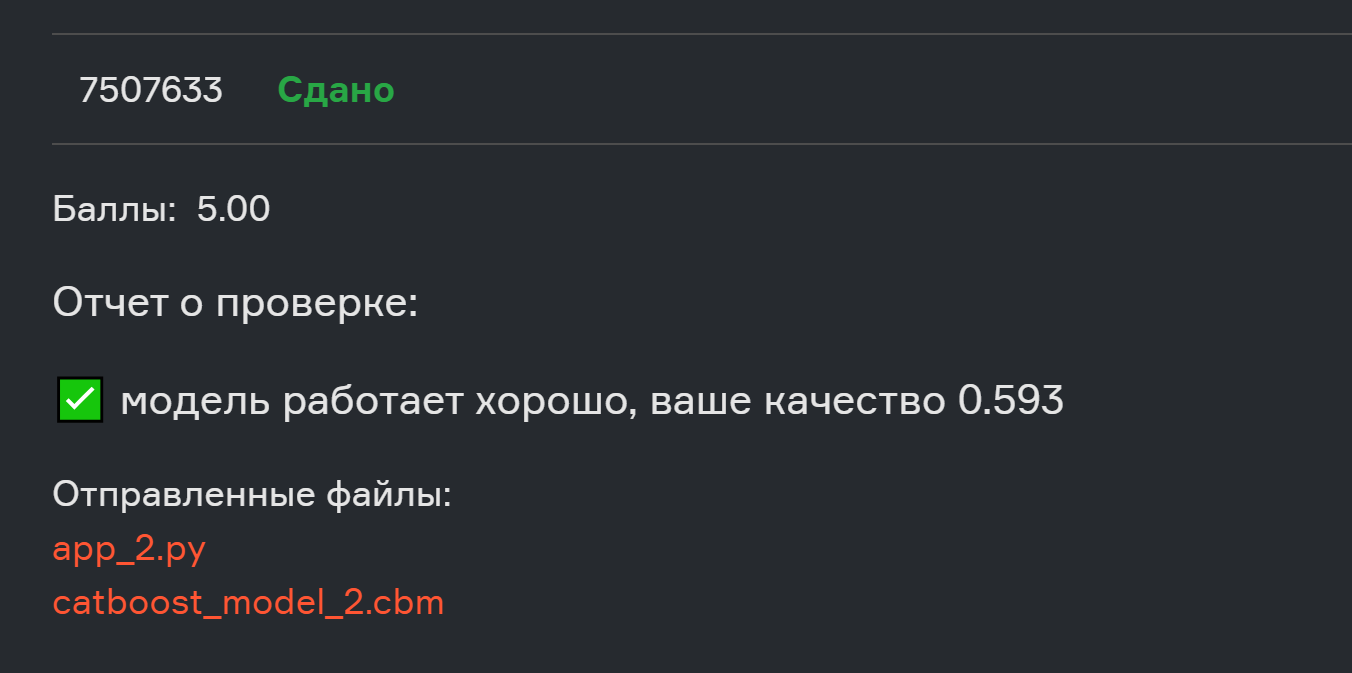

# Итог
В целом удалось разработать сервис согласно поставленной задачи и при этом уложиться в рамки требований по метрике и техническим ограничениям, проект можно использовать
* Среднее время работы одного запроса не более __~0,5 секунд__. 
* Ограничение по памяти: не больше, чем __~4 гб RAM__ на запуск 
* HitRate@5 больше чем __0.57__
